# Parcial 2. Clasificación de imágenes a partir de redes Convolucionales.

En esta actividad se aborda el problema de la clasificación de imágenes utilizando la base de datos CIFAR-10 (https://www.cs.toronto.edu/~kriz/cifar.html). Cada grupo de trabajo deberá diseñar y ejecutar una solución basada en redes neuronales convolucionales. Se considerarán dos aspectos principales para la evaluación del trabajo:

1. Planeación: antes de comenzar a diseñar cualquier modelo, cada grupo debe describir detalladamente la solución que plantea. Es importante que se justifiquen todas las decisiones tomadas (por ejemplo, la función de costo y la función de activación en la capa de salida). Además, se deben tener en cuenta características como el tipo de imágenes (a color), la cantidad de datos en el conjunto de entrenamiento y la cantidad de clases. Este elemento representa el 30% de la nota.

2. Ejecución: una vez descrita la solución propuesta, se procede a su implementación. Cada grupo debe asegurarse de que la implementación siga fielmente lo descrito en la propuesta, y justificar cualquier cambio que se realice en la ejecución. Este elemento representa el 70% de la nota.


Es importante destacar que las decisiones tomadas en la planeación que no estén debidamente justificadas pueden afectar la nota de ambos elementos.

¡Buena suerte!


**Carga de Datos**

In [ ]:
import tensorflow as tf

import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras.utils import to_categorical
from keras import regularizers
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, BatchNormalization
from keras.optimizers import SGD, Adam
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt 


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image

In [ ]:
# Load the CIFAR-10 dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Preprocess the data
X_train = X_train / 255.0
X_test = X_test / 255.0

# 1. Planeación

Como presentamos una base de datos de imágenes a color, tendremos en cuenta los siguientes pasos para plantear la red convolucional:



1.   Una imagen a color, agrega un nuevo canal referente al RGB de la imagen.
2.   Analizaremos la data, en cuanto a cantidad de datos y categorías de clasificación que presenta.
3. Realizaremos un pre-procesamiento que lo que nos permite hacer, es normalizar los datos o representar las imágenes que presentan escala de 0-255 en RGB, a una escala de 0-1, que es lo que la red puede procesar. Pero no realizamos un **flatenning**, debido a que vamos a mantener el tamaño de las imágenes.
4. Se hará la división de la data de entrenamiento con un 30 % de validación y 70 % para el entrenamiento.
5. Codificaremos los labels/etiquetas. Dado que estas se encuentran almacenadas como una lista de 10 valores, que hace referencia a las 10 clases. Además, todos los valores son cero excepto el índice que hace referencia a la clase que pertenece la imagen.
6. Se crea un modelo de red convolucional

*  Para este modelo se plantearon:
    1. Un modelo secuencial y comenzamos a agregar capas una por una.
    2. Las primeras capas Conv2D están precedidas por MaxPooling2D y la capa Dropout
    3. Luego, se agregan 3 capas Conv2D, seguidas nuevamente por una capa de Pooling y Dropout, seguida de 2 capas **Dense Fully-Connected** que conducen a una capa de salida. El **kernel_size** y **pool_size** son los mismos en toda la red.
    4. Los filtros duplican su tamaño con cada capa a partir de **128** subiendo a **512** y volviendo a **256** en la quinta capa. 
    5. Se utilizaron valores similares para las neuronas en la capa Fully-Connected. Esta configuración fue la que mejor **Accuracy** obtuvo, aunque puede ser computacionalmente costosa.
    

7. Se va a usar función de activación **relu**, dado que se ha demostrado que es la que mejor resultados obtiene, además, en términos de costo computacional es muy bueno y por otro lado, ayuda a prevenir el problema del desvanecimiento del gradiente.
8. Además, se utilizó un **padding/relleno** para que la imagen de salida tenga el mismo tamaño que la original. 
9. Se va usar el optimizador **adam**, debido a que adapta su capacidad de aprendizaje para el entrenamiento y la actualización precisa de los pesos de la red neuronal.
10. Se va a usar la función de activación para la última capa de **softmax**, ya que presentamos un problema de clasificación de múltiples clases.
11. Se analizan los resultados para evaluar si presenta sub-ajuste, sobre-ajuste, gradiente que explotan o desvanecen.

  **En caso dado de que se presente, se debe de regularizar el modelo**

# 2. Implementación

# **Desarrollo**

In [ ]:
print("X train")
print(X_train.shape)
print(X_test.shape)

X train
(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [ ]:
print("Y train")
print(y_train.shape)
print(y_test.shape)

Y train
(50000, 1)
(10000, 1)


Como se puede evidenciar, las imágenes tienen tamaño de 32x32. A continuación, se muestran algunos ejemplos.

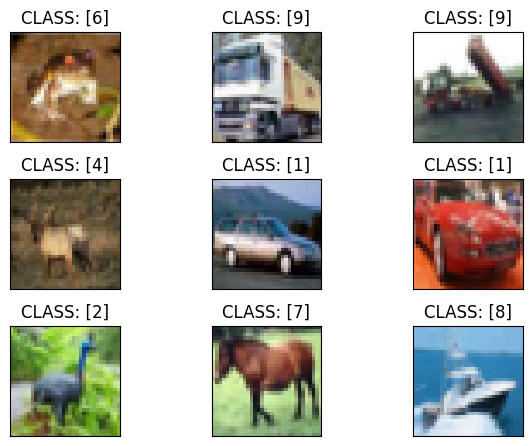

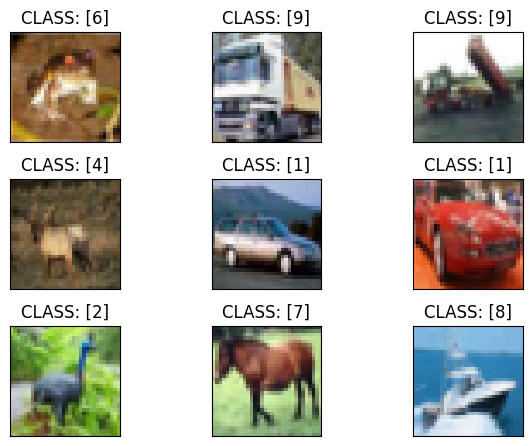

In [ ]:
fig = plt.figure()
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.tight_layout()
  plt.imshow(X_train[i], cmap='gray', interpolation='none')
  plt.title("CLASS: {}".format(y_train[i]))
  plt.xticks([])
  plt.yticks([])
fig

**Conocer las clases que existen**

In [ ]:
clases = np.unique(y_train)
nombres_clases = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
i=0
for clase in clases:
    print(clase,':',nombres_clases[i])
    i=i+1
    
num_clases = len(clases)
print('Numero total de clases: ', num_clases)
print('Tipos de clases: ', clases)

0 : airplane
1 : automobile
2 : bird
3 : cat
4 : deer
5 : dog
6 : frog
7 : horse
8 : ship
9 : truck
Numero total de clases:  10
Tipos de clases:  [0 1 2 3 4 5 6 7 8 9]


Como se evidencia, existen 10 tipos de clases para clasificar.

**Aplicamos el One Hot Enconding.**

Dividimos los vectores de las etiquetas en columnas. Por ejemplo:

  >Avión --> [1,0,0,0,0,0,0,0,0,0]

  >Coche --> [0,1,0,0,0,0,0,0,0,0]
  
  >Pájaro --> [0,0,1,0,0,0,0,0,0,0]

In [ ]:
y_train = tf.keras.utils.to_categorical(y_train, num_clases)
y_test = tf.keras.utils.to_categorical(y_test, num_clases)

#print(y_train[0])
#print(y_test[0])

**Dividimos la Data en Datos de Entrenamiento y Validación**

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3)
print("Training")
print(X_train.shape)
print(y_train.shape)

print("\nValidation")
print(X_valid.shape)
print(y_valid.shape)

Training
(35000, 32, 32, 3)
(35000, 10)

Validation
(15000, 32, 32, 3)
(15000, 10)




>  **Definición de Red**



In [ ]:
def cnn_model():
    
    model = Sequential()
    
    # Primera Capa
    model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4), input_shape=(32,32,3)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.3))
    
    # Segunda Capa
    model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.3))
    
    # Tercera, Cuarta, Quinta Capa
    model.add(Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4)))
    model.add(Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4)))
    model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.3))

    # Capas Red Fully Connected
    model.add(Flatten())
    
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(10, activation='softmax'))
    
    model.summary()
    
    return model

**Data Augmentation**

Se decidió hacer un **Data Augmentation** con variaciones aleatorias de imágenes, como por ejemplo, **rotarlas 15 grados, cambiar el ancho y la altura**, entre otros.

Esto con el fin de hacer que el modelo se generalizara mejor y redujera el sobre-ajuste al mismo tiempo que aumentaba un poco la precisión. De igual forma, se empleó la **regularización L2** para atacar este problema.


In [ ]:
datagen = ImageDataGenerator(featurewise_center=False,
                            samplewise_center=False,
                            featurewise_std_normalization=False,
                            samplewise_std_normalization=False,
                            zca_whitening=False,
                            rotation_range=15,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            horizontal_flip=True,
                            vertical_flip=False)

datagen.fit(X_train)

**Inicialiamos el modelo**

In [ ]:
model = cnn_model()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 32, 32, 128)       3584      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 16, 16, 128)      0         
 2D)                                                             
                                                                 
 dropout_18 (Dropout)        (None, 16, 16, 128)       0         
                                                                 
 conv2d_16 (Conv2D)          (None, 16, 16, 256)       295168    
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 8, 8, 256)        0         
 g2D)                                                            
                                                                 
 dropout_19 (Dropout)        (None, 8, 8, 256)        

**Definimos la funcion que evaluara el entrenamiento contra la validación y la graficará**

In [ ]:
def evaluate(model, history):
    # Se evalúa el accuracy del modelo tanto en el conjunto de entrenamiento como 
    # en el de prueba.
    _, train_accuracy = model.evaluate(X_train, y_train)
    _, test_accuracy = model.evaluate(X_valid, y_valid)

    print(f"Trainining accuracy: {train_accuracy:.2f}")
    print(f"Testing accuracy: {test_accuracy:.2f}")

    # Se grafica la función de pérdida para los conjuntos de entrenamiento y 
    # prueba.
    plt.figure(figsize=(6, 4), dpi=160)

    plt.plot(history.history["loss"], label="train")
    plt.plot(history.history["val_loss"], label="test")
    plt.legend()
    plt.show()

**Compilamos el modelo**

In [ ]:
model.compile(loss='categorical_crossentropy',
             optimizer=Adam(lr=0.0003, decay=1e-6),
             metrics=['accuracy'])


/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
history3 = model.fit_generator(datagen.flow(X_train, y_train, batch_size = 64),
                    steps_per_epoch = len(X_train) // 64, 
                    epochs = 100, 
                    validation_data= (X_valid, y_valid),
                    verbose=1)


Epoch 1/100


<ipython-input-82-f4633afa7869>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history3 = model.fit_generator(datagen.flow(X_train, y_train, batch_size = 64),


546/546 [==============================] - 29s 51ms/step - loss: 2.2152 - accuracy: 0.1786 - val_loss: 1.8647 - val_accuracy: 0.3189
Epoch 2/100
546/546 [==============================] - 26s 48ms/step - loss: 1.8241 - accuracy: 0.3113 - val_loss: 1.5077 - val_accuracy: 0.4464
Epoch 3/100
546/546 [==============================] - 26s 48ms/step - loss: 1.6085 - accuracy: 0.4090 - val_loss: 1.3766 - val_accuracy: 0.4999
Epoch 4/100
546/546 [==============================] - 27s 48ms/step - loss: 1.4716 - accuracy: 0.4787 - val_loss: 1.2064 - val_accuracy: 0.5704
Epoch 5/100
546/546 [==============================] - 27s 50ms/step - loss: 1.3771 - accuracy: 0.5233 - val_loss: 1.1937 - val_accuracy: 0.5840
Epoch 6/100
546/546 [==============================] - 28s 52ms/step - loss: 1.2914 - accuracy: 0.5568 - val_loss: 1.0705 - val_accuracy: 0.6355
Epoch 7/100
546/546 [==============================] - 26s 48ms/step - loss: 1.2379 - accuracy: 0.5850 - val_loss: 1.0279 - val_accuracy: 0.64

469/469 [==============================] - 3s 6ms/step - loss: 0.6669 - accuracy: 0.8582
Trainining accuracy: 0.94
Testing accuracy: 0.86


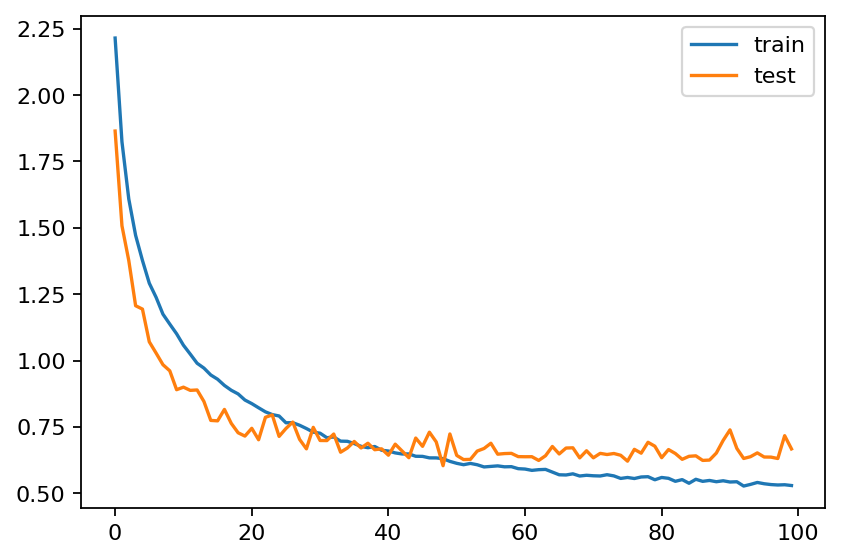

In [ ]:
# Finalmente, se evalúa el rendimiento del modelo en el conjunto de entrenamiento.
evaluate(model,history3)

### **FIN DEL PROGRAMA**